# Student Infomation
**Student ID:** 19021222 <br>
**Fullname:** Trần Xuân Bách <br>
**Class:** INT3405E_20

# Problem Statement
Khách hàng của HomeDepot hàng ngày đều lên trang tìm kiếm sản phẩm của họ để có thể mua các sản phẩm mới nhất một cách nhanh nhất có thể cho nhu cầu sửa chữa, cải thiện nhà cửa của họ. Chính vì vậy họ mong muốn chỉ với vài cái click chuột và tìm kiếm thì có thể tìm thấy ngay sản phẩm mà họ đang cần nhanh chóng và chính xác.<br>
Với cuộc thi này Home Depot muốn các Kagglers giúp họ cải thiện trải nghiệm của khách hàng bằng cách tạo ra một model có thể dự đoán chính xác sự liên quan của từ khóa tìm kiếm của khách hàng với các sản phẩm của họ.<br>
Search relevancy là một thước đo ngầm giúp Home Depot có thể đưa đến khách hàng đúng sản phẩm phù hợp với nhu cầu. Hiện tại việc đánh giá relevance còn khá thủ công và họ muốn giảm thiếu hoặc loại bỏ công sức của con người cần bỏ ra cho công việc này.<br>

## Input:
Dữ liệu đầu vào là thông tin sản phẩm (tên, mô tả, tên thuộc tính và các giá trị của thuộc tính), dữ liệu về từ khóa tìm kiếm.

## Output:
Số điểm relevance (từ 1 đến 3) thể hiện mức độ liên quan của từ khóa tìm kiếm đến các sản phẩm.

# Load data and dependency

In [ ]:
import pandas as pd
import sklearn as sk
import regex as re
import nltk
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tqdm import tqdm
import json
tqdm.pandas()

In [ ]:
train_df = pd.read_csv('../input/home-depot-product-search-relevance/train.csv.zip', encoding='ISO-8859-1')
test_df = pd.read_csv('../input/home-depot-product-search-relevance/test.csv.zip', encoding='ISO-8859-1')
des_df = pd.read_csv('../input/home-depot-product-search-relevance/product_descriptions.csv.zip', encoding='ISO-8859-1')
attributes_df = pd.read_csv('../input/home-depot-product-search-relevance/attributes.csv.zip', encoding="ISO-8859-1")

In [ ]:
# Đọc file màu (từ repo top 3 private leaderboard)
colors = None
with open("../input/home-depot-spell-check/color.json", encoding = 'utf-8') as f:
    colors = json.loads(f.read())

# Đọc file sửa lỗi chính tả theo từ trong dataset (lấy từ một notebook trên forum của dataset này)
dict_replace = None
with open("../input/home-depot-spell-check/dict_replace.json", encoding = 'utf-8') as f:
    dict_replace = json.loads(f.read())

# Đọc file sửa lỗi chính tả search_term theo cả cụm (lấy từ một notebook trên forum của dataset này)
spell_check = None
with open("../input/home-depot-spell-check/spell_check.json", encoding = 'utf-8') as f:
    spell_check = json.loads(f.read())

# Data Exploration

In [ ]:
train_df.head(5)

In [ ]:
test_df.head(5)

In [ ]:
des_df.head(5)

In [ ]:
attributes_df.head(5)

## File Description
* ```train.csv``` - Chứa các thông tin về sản phẩm (id, tiêu đề), từ khóa tìm kiếm và đánh giá sự liên quan của từ khóa đó với sản phẩm theo thang điểm từ 1 đến 3.
* ```test.csv``` - Tương tự với training set ngoại trừ không có cột chứa thang điểm đánh giá sự liên quan của từ khóa tìm kiếm với sản phẩm.
* ```product_descriptions.csv``` - Chứa thông tin mô tả sản phẩm (id, mô tả) dưới dạng text
* ```attributes.csv``` - Chứa các thuộc tính của sản phẩm (mỗi hàng sẽ là id sản phẩm, tên thuộc tính, giá trị thuộc tính)
* ```sample_submission.csv``` - File submission mẫu của cuộc thi
* ```relevance_instructions.docx``` - Chứa chỉ dẫn về cách đánh giá điểm của từ khóa tìm kiếm với sản phẩm (theo thang từ 1 đến 3 do 3 người đánh giá và lấy giá trị trung bình)

## Data fields
* ```id``` : index của cặp search_term và product_id
* ```product_uid```: ID của sản phẩm
* ```product_title```: Tiêu đề của sản phẩm
* ```product_description```: Mô tả thông tin của sản phẩm
* ```search_term```: Query tìm kiếm
* ```relevance```: Đánh giá sự liên quan của từ khóa tìm kiếm với sản phẩm
* ```name```: Tên thuộc tính của sản phẩm (Bullet01, Bullet02, ...)
* ```value```: Giá trị ứng với tên thuộc tính tương ứng(Ví dụ: thuộc tính Bullet04 có giá trị là Dimensions: 3 in. x 3 in. x 1-1/2 in.)

## Explore each dataframe

### Train Set and Test Set

Dữ liệu train bao gồm 74066 records, ngoài ra không có phần tử nào bị rỗng trong bảng train. Relevance có giá trị trung bình là 2.381634 với độ lệch chuẩn mẫu (sample standard deviation) là 0.533984 với số lượng mẫu khá lớn là 74067 thì độ lệch chuẩn này khá gần với độ lệch chuẩn toàn cục (population standard deviation). Vì vậy model mong đợi cần dự đoán với sai số RMSE trên tập test (split từ training set) ít nhất là nhỏ hơn con số trên (tốt hơn việc đoán toàn bộ là giá trị trung bình 2.38)

In [ ]:
print('Train set:  ')
print(train_df.isna().sum())
print(train_df.describe())
print('----------------------')
print('Test set')
print(test_df.isna().sum())

In [ ]:
print("Số lượng search term unique trong tập train: ", len(train_df.search_term.unique()))
print("Số lượng sản phẩm unique trong tập train: ", len(train_df.product_uid.unique()))

print("Số lượng search term unique trong tập test: ", len(test_df.search_term.unique()))
print("Số lượng sản phẩm unique trong tập test: ", len(test_df.product_uid.unique()))

Số lượng các từ khóa tìm kiếm độc lập là 11795, chiếm 16% tổng số phần tử của tập train <br>
Số lượng các sản phẩm độc lập là 54667, chiếm 73.8% tổng số phần tử của tập train

In [ ]:
print('Số lượng các hàng có search_term và product_uid trùng lặp (Train set): ',train_df[['search_term', 'product_uid']].duplicated().sum())
print('Số lượng các hàng có search_term và product_uid trùng lặp (Test set): ',test_df[['search_term', 'product_uid']].duplicated().sum())

In [ ]:
print(des_df.isna().sum())
print("Có tổng cộng", len(des_df),"sản phẩm")
print("Có", des_df['product_uid'].duplicated().sum(),"sản phẩm trùng nhau")

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
set1 = set(train_df.product_uid.to_list())
set2 = set(test_df.product_uid.to_list())
venn2([set1, set2], ('Train set', 'Test set'))
plt.title("Venn Diagram cụm sản phẩm trùng lặp")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
set1 = set(train_df.search_term.to_list())
set2 = set(test_df.search_term.to_list())
venn2([set1, set2], ('Train set', 'Test set'))
plt.title("Venn Diagram cụm search_term trùng lặp")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
set1 = set(train_df['search_term'].astype(str) + ' ' + train_df['product_uid'].astype(str))
set2 = set(test_df['search_term'].astype(str) + ' ' + test_df['product_uid'].astype(str))
venn2([set1, set2], ('Train set', 'Test set'))
plt.title("Venn Diagram cụm search_term và sản phẩm trùng lặp")
plt.show() 

Có tổng cộng 27699 sản phẩm trùng lặp giữa train set và test set.<br>
Hầu hết các search_term trong train set đều tồn tại trong test set <br>
Các cụm search_term và sản phẩm không có sự trùng lặp giữa 2 tập train và test

In [ ]:
train_df['relevance'].value_counts().sort_index(ascending=False).plot(kind='barh')

Training set có phân bố nghiêng về mức high relevance (từ 2.67 đến 3) và có khá ít các giá trị điểm thấp

In [ ]:
fig, axs = plt.subplots(2, figsize=(10,10))
fig.suptitle('Length of search_term')
lens_train = train_df.progress_apply(lambda x: len(x['search_term']), axis=1)
lens_train.hist(ax=axs[0])
lens_test = test_df.progress_apply(lambda x: len(x['search_term']), axis=1)
lens_test.hist(ax=axs[1])
axs[0].set_title('Train set')
axs[1].set_title('Test set')

Các search_term trong train set và test set có độ dài khá tương đồng và phân phối gần phân phối chuẩn với mean là khoảng 16

In [ ]:
fig, axs = plt.subplots(2, figsize=(10,10))
fig.suptitle('Length of search_term')
# lens_train = train_df.progress_apply(lambda x: len(x['search_term']), axis=1)
train_df['product_uid'].hist(ax=axs[0])
# lens_test = test_df.progress_apply(lambda x: len(x['search_term']), axis=1)
test_df['product_uid'].hist(ax=axs[1])
axs[0].sharex(axs[1])
axs[0].set_title('Train set')
axs[1].set_title('Test set')

Tần suất xuất hiện của các sản phẩm cũng không tương đồng nhau, một số sản phẩm có uid thấp xuất hiện khá nhiều trong cả 2 tập dữ liệu (tương đồng trên cả 2 tập).

### Attributes dataframe

In [ ]:
attributes_df.isna().sum()

Có 155 hàng có cột product_uid không có giá trị, 155 hàng có cột name không có giá trị và 2284 hàng có cột value không có giá trị trong bảng thuộc tính sản phẩm. Điều này khá hiển nhiên bởi vì có 1 số sản phẩm không có một vài thuộc tính, tuy nhiên lẽ ra thuộc tính không có giá trị thì chúng không nên được đưa vào bảng này và để rỗng như vậy.

In [ ]:
# Có uid nhưng không có value
attributes_df[np.invert(attributes_df.isnull().product_uid) & attributes_df.isnull().value]
# Có value nhưng ko có uid thì không có trường hợp nào cả

Các hàng có product_uid rỗng thì name cũng sẽ rỗng, các hàng có value rỗng thì có thể chỉ value rỗng hoặc cả 3 cột đều rỗng.

In [ ]:
# Không có uid
attributes_df[attributes_df.isnull().product_uid].isnull().sum()
# Các trường hợp ko có uid thì sẽ ko có cả các trường còn lại.

In [ ]:
attributes_df.product_uid.dropna().astype('int64')

Hầu hết các sản phẩm đều có brand name và một vài thuộc tính khác

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
set1 = set(attributes_df.product_uid.dropna().astype('int64'))
set2 = set(des_df.product_uid)
venn2([set1, set2], ('attribute', 'description'))
plt.title("Venn Diagram các sản phẩm trong attribute table và description table")
plt.show() 

Như vậy bảng description là đầy đủ nhất, chứa toàn bộ các sản phẩm có trong cả train set, test set và các sản phẩm có trong bảng attributes.

In [ ]:
attributes_df.name.value_counts().plot()

Chỉ có một số lượng rất nhỏ các thuộc tính là có số lượng lớn sản phẩm đều có, còn đa phần các thuộc tính còn lại đều có rất ít các sản phẩm có chúng.<br>
Các sản phẩm có thuộc tính thì đều sẽ có brand name

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
set1 = set(attributes_df[attributes_df['name'] == 'MFG Brand Name'].product_uid.astype('int64'))
set2 = set(des_df.product_uid)
venn2([set1, set2], ('attribute', 'description'))
plt.title("Số lượng sản phẩm có brand name")
plt.show() 

Nhìn vào Venn Diagram ở trên và trên nữa, có thể thấy chỉ có 13 sản phẩm là không có Brand Name, hoàn toàn có thể fill null bằng 1 giá trị nào đó và ít ảnh hưởng đến dataset, việc sử dụng Brand khá quan trọng vì thang điểm relevance được tính dựa trên Brand Name có khớp hay không.

# Data processing

## Drop null value

In [ ]:
# Drop cột id không cần thiết của bảng train
train_df = train_df.drop(['id'], axis=1)


# Drop null value bảng attribute
attributes_df = attributes_df.dropna()

# Bảng attribute lỗi cột uid là dạng float64 nên convert sang int64 để đồng bộ với bảng khác
attributes_df = attributes_df.astype({'product_uid': 'int64'})

# Lấy dữ liệu về branding để phục vụ sau này (khi nối các cột name và value của bảng attribute sẽ không lấy lại đc các giá trị brand)
brand_temp = attributes_df[attributes_df['name'] == 'MFG Brand Name']
brand_temp['brand'] = brand_temp['value']
brand_temp = brand_temp.drop(['name', 'value'], axis=1)

## Join các hàng attribute

Với mỗi hàng trong bảng attribute là ứng với 1 thuộc tính của 1 sản phẩm, chúng ta sẽ join các hàng của chúng lại với nhau thành 1 hàng ứng với toàn bộ thuộc tính của 1 sản phẩm

In [ ]:
# Nối 2 cột Name và value lại thành 1 cột là att_summary
attributes_df['att_summary'] = attributes_df.progress_apply(lambda x: (x['name'] + ' ' + x['value']) ,axis=1)

# Bỏ 2 cột cũ (sau khi đã nối xong)
attributes_df = attributes_df.drop(labels=['name', 'value'], axis=1)

# Tạo bảng mới (pivot table) có index là product_uid và với các hàng có cùng product_uid sẽ tiến hành join chúng lại thành 1.
attributes_df = pd.pivot_table(attributes_df, index='product_uid', aggfunc= lambda x : " ".join(x))

Kết quả thu được bảng có format dạng ```product_uid``` kèm theo cột ```att_summary```  ``` tên_thuộc_tính_1 giá_trị_thuộc_tính_1 tên_thuộc_tính_2 giá_trị_thuộc_tính_2 ...``` như sau:

In [ ]:
attributes_df

## Merge các bảng lại với nhau
Để cho thuận tiện trong việc training và trích chọn đặc trưng thì chúng ta sẽ merge các bảng lại thành một bảng (dựa theo index là uid của sản phẩm)

### Merge description vào bảng train

In [ ]:
train_df = train_df.merge(des_df, on='product_uid', how='left')

test_df = test_df.merge(des_df, on='product_uid', how='left')

train_df


### Merge attribute vào bảng train

In [ ]:
train_df = train_df.merge(attributes_df, on='product_uid', how='left')
test_df = test_df.merge(attributes_df, on='product_uid', how='left')
train_df

### Merge Brand vào bảng train

In [ ]:
train_df = train_df.merge(brand_temp, on='product_uid', how='left')
test_df = test_df.merge(brand_temp, on='product_uid', how='left')
train_df

Có 13 sản phẩm không có brand name và có 38k sản phẩm không có Attribute nên cần fill giá trị rỗng của chúng để tiện xử lý sau này.

In [ ]:
train_df['att_summary'] = train_df['att_summary'].fillna('NoAttribute')
train_df['brand'] = train_df['brand'].fillna('NoBrand')
train_df.isna().sum()

test_df['att_summary'] = test_df['att_summary'].fillna('NoAttribute')
test_df['brand'] = test_df['brand'].fillna('NoBrand')

### Bỏ ký tự đặc biệt, sửa chính tả

Có khá nhiều lỗi chính tả trong search term (mặc dù lỗi chính tả góp phần làm giảm điểm relevance đi so với đúng chính tả trong train set, ví dụ: từ rustoleum so với rust oleum cho cùng 1 sản phẩm thì viết đúng chính tả sẽ cho điểm relevance cao hơn ở training set tuy nhiên chúng sẽ gây nhiễu khá lớn và khiến model khó có thể tốt được bởi số lượng quá lớn).<br>
File spell_check.json được lấy từ một discussion của cuộc thi này (sử dụng google search để check lỗi).<br>
Có thể sử dụng các thư viện sửa lỗi tuy nhiên các search term ở đây bias về phía các từ liên quan đến home depot dẫn đến các corrector lib đó thường cho kết quả khá sai lệch (đã thử với autocorrector, SymSpell và một vài thư viện dạng statistical based nhưng tác dụng không tốt lắm). 

In [ ]:
def search_term_correction(s):
    # Kiểm tra cụm search_term có trong danh sách spell check hay không, nếu có thì sửa lại
    if s in spell_check.keys():
        s = spell_check[s]
    s = s.lower().strip().split(' ')
    
    # Kiểm tra các word của search_term có trong file dict_replace hay không, 
    # nếu có thì sửa lại sau đó join list lại thành string ban đầu
    for index, i in enumerate(s):
        if i in dict_replace.keys():
            s[index] = dict_replace[i]
    s = ' '.join(s)
    return s

train_df['search_term'] = train_df.progress_apply(lambda x: search_term_correction(x['search_term']), axis=1)

test_df['search_term'] = test_df.progress_apply(lambda x: search_term_correction(x['search_term']), axis=1)

Loại bỏ các ký tự đặc biệt trong câu như @, -, $, ...

In [ ]:
print("Test Regex [^A-Za-z0-9]+ for this string 90Â° : " + re.sub('[^A-Za-z0-9]+', ' ', ' 90Â°'))
def remove_special_char(row):
    row['product_title'] = re.sub('[^A-Za-z0-9]+', ' ', row['product_title'])
    row['search_term'] = re.sub('[^A-Za-z0-9]+', ' ', row['search_term'])
    row['product_description'] = re.sub('[^A-Za-z0-9]+', ' ', row['product_description'])
    row['att_summary'] = re.sub('[^A-Za-z0-9]+', ' ', row['att_summary'])

    row['product_title'] = row['product_title'].lower()
    row['search_term'] = row['search_term'].lower()
    row['product_description'] = row['product_description'].lower()
    row['att_summary'] = row['att_summary'].lower()
    return row
train_df = train_df.progress_apply(remove_special_char, axis=1)

test_df = test_df.progress_apply(remove_special_char, axis=1)

### Chuẩn hóa đơn vị đo lường

Các search_term thường viết các đơn vị đo lường theo nhiều cách khác nhau nên cần đưa về 1 dạng ví dụ 2 inches, 2in. -> 2 in 

In [ ]:
def measurement_standardize(s):
    s = re.sub(r"([0-9])( *)\.( *)([0-9])", r"\1.\4", s)
    s = re.sub(r"([0-9]+)( *)(inches|inch|in|')\.?", r"\1 in. ", s)
    s = re.sub(r"([0-9]+)( *)(foot|feet|ft|'')\.?", r"\1 ft. ", s)
    s = re.sub(r"([0-9]+)( *)(pounds|pound|lbs|lb)\.?", r"\1 lb. ", s)
    s = re.sub(r"([0-9]+)( *)(square|sq) ?\.?(feet|foot|ft)\.?", r"\1 sq.ft. ", s)
    s = re.sub(r"([0-9]+)( *)(cubic|cu) ?\.?(feet|foot|ft)\.?", r"\1 cu.ft. ", s)
    s = re.sub(r"([0-9]+)( *)(gallons|gallon|gal)\.?", r"\1 gal. ", s)
    s = re.sub(r"([0-9]+)( *)(ounces|ounce|oz)\.?", r"\1 oz. ", s)
    s = re.sub(r"([0-9]+)( *)(centimeters|cm)\.?", r"\1 cm. ", s)
    s = re.sub(r"([0-9]+)( *)(milimeters|mm)\.?", r"\1 mm. ", s)
    s = s.replace("°"," degrees ")
    s = re.sub(r"([0-9]+)( *)(degrees|degree)\.?", r"\1 deg. ", s)
    s = s.replace(" v "," volts ")
    s = re.sub(r"([0-9]+)( *)(volts|volt)\.?", r"\1 volt. ", s)
    s = re.sub(r"([0-9]+)( *)(watts|watt)\.?", r"\1 watt. ", s)
    s = re.sub(r"([0-9]+)( *)(amperes|ampere|amps|amp)\.?", r"\1 amp. ", s)
    s = re.sub(' +', " ", s)
    return s
train_df['product_title'] = train_df.progress_apply(lambda x: measurement_standardize(x['product_title']), axis=1)
train_df['search_term'] = train_df.progress_apply(lambda x: measurement_standardize(x['search_term']), axis=1)
train_df['att_summary'] = train_df.progress_apply(lambda x: measurement_standardize(x['att_summary']), axis=1)
train_df['product_description'] = train_df.progress_apply(lambda x: measurement_standardize(x['product_description']), axis=1)

test_df['product_title'] = test_df.progress_apply(lambda x: measurement_standardize(x['product_title']), axis=1)
test_df['search_term'] = test_df.progress_apply(lambda x: measurement_standardize(x['search_term']), axis=1)
test_df['att_summary'] = test_df.progress_apply(lambda x: measurement_standardize(x['att_summary']), axis=1)
test_df['product_description'] = test_df.progress_apply(lambda x: measurement_standardize(x['product_description']), axis=1)


In [ ]:
# train_df.to_csv('w2veccorpus.csv', encoding='utf-8')

Lưu lại file train và test đã qua xử lý để không cần chạy lại lần sau

In [ ]:
train_df.to_csv('processed_train_df.csv', encoding='utf-8')
test_df.to_csv('processed_test_df.csv', encoding='utf-8')

# Feature Engineering

Trích chọn đặc trưng là quá trình chuyển đổi dữ liệu thô thành các đặc trưng thể hiện tốt hơn các pattern cơ bản đối với các mô hình dự đoán, dẫn đến cải thiện độ chính xác của mô hình trên dữ liệu không nhìn thấy.

## Load checkpoint

In [ ]:
train_df = pd.read_csv('./processed_train_df.csv', encoding='utf-8')
train_df = train_df.drop(['Unnamed: 0'], axis=1)
test_df = pd.read_csv('./processed_test_df.csv', encoding='utf-8')
test_df = test_df.drop(['Unnamed: 0', 'id'], axis=1)

## Search term length
Độ dài của search_term 

In [ ]:
train_df['query_length'] = train_df.progress_apply(lambda x: len(x['search_term']), axis=1)
test_df['query_length'] = test_df.progress_apply(lambda x: len(x['search_term']), axis=1)

## Last word in title
Thông thường, khi tìm kiếm một sản phẩm nào đó (English) thì người ta sẽ thường tìm kiếm theo format thuộc tính + sản phẩm. Chính vì vậy từ khóa cuối thường là tên của loại sản phẩm đó. Vì vậy từ khóa này sẽ có ảnh hưởng đến relevance của sản phẩm.

In [ ]:
train_df['last_word_in_title'] = train_df.progress_apply(lambda x: x['search_term'].split()[-1] in x['product_title'].split(), axis=1)

test_df['last_word_in_title'] = test_df.progress_apply(lambda x: x['search_term'].split()[-1] in x['product_title'].split(), axis=1)

## Last word in description

Tương tự như trên

In [ ]:
train_df['last_word_in_des'] = train_df.progress_apply(lambda x: x['search_term'].split()[-1] in x['product_description'].split(), axis=1)

test_df['last_word_in_des'] = test_df.progress_apply(lambda x: x['search_term'].split()[-1] in x['product_description'].split(), axis=1)

## Have brand, atributes or not

Kiểm tra xem sản phẩm có brand hoặc attribute hay không bởi những sản phẩm như này thường xơ xài và ít được quan tâm và có relevance thấp

In [ ]:
# NoBrand

train_df['have_brand'] = train_df.progress_apply(lambda x: x['brand'] != 'NoBrand', axis=1)

test_df['have_brand'] = test_df.progress_apply(lambda x: x['brand'] != 'NoBrand', axis=1)

In [ ]:
# noattribute
train_df['have_att'] = train_df.progress_apply(lambda x: x['att_summary'] != 'noattribute', axis=1)

test_df['have_att'] = test_df.progress_apply(lambda x: x['att_summary'] != 'noattribute', axis=1)

## Number in attributes
Kiểm tra trong search term có bao nhiêu số trùng với các số có trong attributes của sản phẩm (ví dụ 12in. bracket...)

In [ ]:
def count_number_common(sent1, sent2):
    search_term_tokens = sent1.split(' ')
    # Check từng word trong search_term, và attribute, 
    # nếu là số thì đưa vào set và lấy số phần tử chung ( & ) của 2 set đó
    numbers_search_term = set([i for i in search_term_tokens if i.isdigit()])
    att_tokens = sent2.split(' ')
    numbers_att = set([i for i in att_tokens if i.isdigit()])
    return len(numbers_search_term & numbers_att)

train_df['number_in_att'] = train_df.progress_apply(lambda x: count_number_common(x['search_term'], x['att_summary']), axis=1)

test_df['number_in_att'] = test_df.progress_apply(lambda x: count_number_common(x['search_term'], x['att_summary']), axis=1)

## Number in title 
Tương tự như [Number in attributes](#Number-in-attributes)

In [ ]:
train_df['number_in_title'] = train_df.progress_apply(lambda x: count_number_common(x['search_term'], x['product_title']), axis=1)

test_df['number_in_title'] = test_df.progress_apply(lambda x: count_number_common(x['search_term'], x['product_title']), axis=1)

## Number in description
Tương tự như [Number in attributes](#Number-in-attributes)

In [ ]:
train_df['number_in_des'] = train_df.progress_apply(lambda x: count_number_common(x['search_term'], x['product_description']), axis=1)

test_df['number_in_des'] = test_df.progress_apply(lambda x: count_number_common(x['search_term'], x['product_description']), axis=1)

## Common word count

Đếm số lượng các từ có chung giữa search_term và title, description, attributes (theo dạng ngrams ví dụ dưới code 2 câu ```this is a test``` và ```abc is a abc a test``` có 2 bigram chung là ```is a``` và ```a test```). Ở đây chỉ sử dụng ngrams = 1 và 2

In [ ]:
from nltk import ngrams
from nltk.metrics import edit_distance

def common_words_count_ngram(sent1, sent2, ngram=1, edit_distance_thresshold=0):
    sent1 = sent1.split(' ')
    sent2 = sent2.split(' ')
    ngrams1 = set(ngrams(sent1, ngram))
    ngrams2 = set(ngrams(sent2, ngram))
    # Sau khi có list 1 gram or bigram của 2 câu thì for loop qua từng pair của 2 câu
    # Nếu edit distance của 2 phần từ nhỏ hơn ngưỡng nào đó (default = 0) thì common words tăng lên 1
    if edit_distance_thresshold == 0:
        return len(ngrams1 & ngrams2)
    else:
        count = 0
        for i in ngrams1:
            for j in ngrams2:
                if edit_distance(i, j) <= edit_distance_thresshold:
                    count+=1
        return count
a = 'This is a test'
b = 'abc is a abc a test'
common_words_count_ngram(a,b, ngram=2)

In [ ]:
train_df['title_common_words_count'] = train_df.progress_apply(lambda x: common_words_count_ngram(x['search_term'], x['product_title'], edit_distance_thresshold=1), axis=1)
train_df['des_common_words_count'] = train_df.progress_apply(lambda x: common_words_count_ngram(x['search_term'], x['product_description'], edit_distance_thresshold=1), axis=1)
train_df['att_common_words_count'] = train_df.progress_apply(lambda x: common_words_count_ngram(x['search_term'], x['att_summary'], edit_distance_thresshold=1), axis=1)

test_df['title_common_words_count'] = test_df.progress_apply(lambda x: common_words_count_ngram(x['search_term'], x['product_title'], edit_distance_thresshold=1), axis=1)
test_df['des_common_words_count'] = test_df.progress_apply(lambda x: common_words_count_ngram(x['search_term'], x['product_description'], edit_distance_thresshold=1), axis=1)
test_df['att_common_words_count'] = test_df.progress_apply(lambda x: common_words_count_ngram(x['search_term'], x['att_summary'], edit_distance_thresshold=1), axis=1)

In [ ]:
train_df['title_common_words_count_2gram'] = train_df.progress_apply(lambda x: common_words_count_ngram(x['search_term'], x['product_title'], ngram=2, edit_distance_thresshold=4), axis=1)
train_df['des_common_words_count_2gram'] = train_df.progress_apply(lambda x: common_words_count_ngram(x['search_term'], x['product_description'], ngram=2,edit_distance_thresshold=4), axis=1)
train_df['att_common_words_count_2gram'] = train_df.progress_apply(lambda x: common_words_count_ngram(x['search_term'], x['att_summary'], ngram=2,edit_distance_thresshold=4), axis=1)

test_df['title_common_words_count_2gram'] = test_df.progress_apply(lambda x: common_words_count_ngram(x['search_term'], x['product_title'], ngram=2, edit_distance_thresshold=4), axis=1)
test_df['des_common_words_count_2gram'] = test_df.progress_apply(lambda x: common_words_count_ngram(x['search_term'], x['product_description'], ngram=2,edit_distance_thresshold=4), axis=1)
test_df['att_common_words_count_2gram'] = test_df.progress_apply(lambda x: common_words_count_ngram(x['search_term'], x['att_summary'], ngram=2,edit_distance_thresshold=4), axis=1)

## Cosine similarity word level

Tính cosine similarity ở mức word.<br>
Công thức như sau: <br>
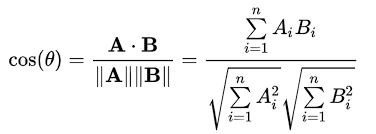 <br>
Công thức này sẽ được tính theo dạng vector Bag of words. Tích $\sum_{i=1}^{n} \text{A}_i \text{B}_i$ sẽ là vector các từ xuất hiện trong cả 2 câu, mẫu số chính là tích căn bậc 2 độ dài của 2 câu

In [ ]:
def cosine_similarity_sent(sent1, sent2):
    set1 = set(sent1.split())
    set2 = set(sent2.split())
    numerator = len(set1 & set2)
    denominator = math.sqrt(len(set1)) * math.sqrt(len(set2))
    
    if not denominator:
        return 0.0
    else:
        return numerator / denominator

train_df['cosine_ST'] = train_df.progress_apply(lambda row: cosine_similarity_sent(row['search_term'], row['product_title']), axis=1) 
train_df['cosine_SD'] = train_df.progress_apply(lambda row: cosine_similarity_sent(row['search_term'], row['product_description']), axis=1)
# train_df['cosine_SB'] = train_df.apply(lambda row: cosine_similarity_sent(row['corrected_search'], row['brand']), axis=1)

test_df['cosine_ST'] = test_df.progress_apply(lambda row: cosine_similarity_sent(row['search_term'], row['product_title']), axis=1) 
test_df['cosine_SD'] = test_df.progress_apply(lambda row: cosine_similarity_sent(row['search_term'], row['product_description']), axis=1)

## Color in title, description, attributes
Kiểm tra có màu sắc chung xuất hiện trong pair search_term với title, search_term với description, search_term với attributes. Danh sách các word màu sắc được lấy từ repo của top 3 private leaderboard, đã được chia sẻ trên forum (team Turing Test), [Link Repo](https://github.com/ChenglongChen/kaggle-HomeDepot/blob/master/Data/dict/color_data.py)

In [ ]:
def have_color(sent1, sent2):
    common_word = set(sent1.strip().split(' ')) & set(sent2.strip().split(' '))
    for i in common_word:
        if i in colors:
            return True
    return False

train_df['color_st_title'] = train_df.progress_apply(lambda x: have_color(x['search_term'], x['product_title']), axis=1)
train_df['color_st_des'] = train_df.progress_apply(lambda x: have_color(x['search_term'], x['product_description']), axis=1)
train_df['color_st_att'] = train_df.progress_apply(lambda x: have_color(x['search_term'], x['att_summary']), axis=1)

test_df['color_st_title'] = test_df.progress_apply(lambda x: have_color(x['search_term'], x['product_title']), axis=1)
test_df['color_st_des'] = test_df.progress_apply(lambda x: have_color(x['search_term'], x['product_description']), axis=1)
test_df['color_st_att'] = test_df.progress_apply(lambda x: have_color(x['search_term'], x['att_summary']), axis=1)


## Search term include brand ?
Kiểu tra số lần Brand Name xuất hiện trong search_term (những search_term có brand của sản phẩm đang xét thường sẽ có relevance cao hơn)

In [ ]:
from nltk.metrics import edit_distance
def includeBrand(search_term, brand, edit_dis_thresshold = 1):
    search_term = search_term.split(' ')
    brand = brand.split(' ')
    count = 0
    for i in search_term:
        for j in brand:
            if edit_distance(i, j) < edit_dis_thresshold:
                count+=1
    return count
    
train_df['search_term_include_brand'] = train_df.progress_apply(lambda x: includeBrand(x['search_term'], x['brand']), axis=1)

test_df['search_term_include_brand'] = test_df.progress_apply(lambda x: includeBrand(x['search_term'], x['brand']), axis=1)

## Jaccard Coefficient và Edit Distance 
Tính Jaccard Coef và Edit Distance nhỏ nhất có thể (giữa 2 word) của search_term và brand, title là bao nhiêu
<img src="https://i.ytimg.com/vi/Ah_4xqvS1WU/maxresdefault.jpg" alt="drawing" style="width:500px;"/><br>
Cách tính của Jaccard Coefficient là số lượng của các từ (unique) có chung trong cả 2 câu chia cho số lượng các từ unique khi union 2 câu.<br>
Cách tính của Edit Distance chỉ đơn giản là cho 2 từ ```"ABC"``` và ```"ADC"``` nếu như cho các hành động thêm, sửa, xóa 1 ký tự nào đó trong từ đều là 1 điểm thì số điểm nhỏ nhất cần bỏ ra để điều chính từ ```"ABC" -> "ADC"``` sẽ tiêu tốn bao nhiêu điểm (Ở trong ví dụ này là 1 điểm).<br>
Ở đây chúng ta có thể thấy khoảng cách nhỏ nhất có thể giữa 2 từ trong search_term và các field khác có ảnh hưởng tới relevance (tìm , ngoài ra tổng khoảng cách cũng có ảnh hưởng.<br>

Ngoài ra mean distance giữa search_term với các field ở đây được tính bằng cách tìm cách sau: (ví dụ đối với description)
* Split search_term thành các word
* Loop qua các word trên và tìm ra word (trong description) có khoảng cách nhỏ nhất với word đang xét (trong search_term)
* Tính tổng các khoảng cách nhỏ nhất đó chia cho length của search_term (bởi vì không có trường hợp search_term rỗng nên sẽ không bao giờ chia cho không)

### Jaccard Coef và Edit Distance Brand và Search_term

In [ ]:
from nltk.metrics.distance import edit_distance
from nltk.metrics.distance import jaccard_distance
from nltk.metrics.distance import edit_distance
from nltk.metrics.distance import jaccard_distance

def min_jaccard_coef(sent1, sent2):
    sent1 = sent1.strip().split(' ')
    sent2 = sent2.strip().split(' ')
    min_dis = 99999
    for i in sent1:
        for j in sent2:
            min_dis = min(jaccard_distance(set(i), set(j)), min_dis)
    return min_dis

def min_edit_distance(sent1, sent2):
    sent1 = sent1.split(' ')
    sent2 = sent2.split(' ')
    min_dis = 99999
    for i in sent1:
        for j in sent2:
            min_dis = min(edit_distance(i, j), min_dis)
    return min_dis

train_df['min_jaccard_brand_with_search_term'] = train_df.progress_apply(lambda x: min_jaccard_coef(x['search_term'], x['brand']), axis=1)
train_df['min_edit_brand_with_search_term'] = train_df.progress_apply(lambda x: min_edit_distance(x['search_term'], x['brand']), axis=1)

test_df['min_jaccard_brand_with_search_term'] = test_df.progress_apply(lambda x: min_jaccard_coef(x['search_term'], x['brand']), axis=1)
test_df['min_edit_brand_with_search_term'] = test_df.progress_apply(lambda x: min_edit_distance(x['search_term'], x['brand']), axis=1)

### Jaccard Coef và Edit Distance Title và Search_term

In [ ]:
train_df['min_jaccard_title_with_search_term'] = train_df.progress_apply(lambda x: min_jaccard_coef(x['search_term'], x['product_title']), axis=1)
train_df['min_edit_title_with_search_term'] = train_df.progress_apply(lambda x: min_edit_distance(x['search_term'], x['product_title']), axis=1)

test_df['min_jaccard_title_with_search_term'] = test_df.progress_apply(lambda x: min_jaccard_coef(x['search_term'], x['product_title']), axis=1)
test_df['min_edit_title_with_search_term'] = test_df.progress_apply(lambda x: min_edit_distance(x['search_term'], x['product_title']), axis=1)

In [ ]:
def getMeanJaccardDistanceSearchTermAndTitle(row):
    search_term_word = row['search_term'].split(' ')
    des_word = row['product_title'].split(' ')
    mean = 0.0
    # Loop qua từng phần tử trong search_term để tìm phần từ có Jaccard Coef nhỏ nhất trong description
    for i in search_term_word:
        if i == '':
            continue
        min_ = 99999
        for j in des_word:
            if j == '':
                continue
            min_ = min(min_, jaccard_distance(set(i), set(j)))
        mean+=min_
    mean = mean/len(search_term_word)
    return mean

train_df['mean_jaccard_product_title_with_search_term'] = train_df.progress_apply(getMeanJaccardDistanceSearchTermAndTitle, axis=1)

test_df['mean_jaccard_product_title_with_search_term'] = test_df.progress_apply(getMeanJaccardDistanceSearchTermAndTitle, axis=1)

In [ ]:
def sum_jaccard_coef(sent1, sent2):
    return jaccard_distance(set(sent1.strip().split(' ')), set(sent2.strip().split(' ')))
def sum_edit_distance(sent1, sent2):
    return edit_distance(sent1, sent2)
    
train_df['sum_jaccard_product_title_with_search_term'] = train_df.progress_apply(lambda x: sum_jaccard_coef(x['search_term'], x['product_title']), axis=1)
train_df['sum_edit_product_title_with_search_term'] = train_df.progress_apply(lambda x: sum_edit_distance(x['search_term'], x['product_title']), axis=1)

test_df['sum_jaccard_product_title_with_search_term'] = test_df.progress_apply(lambda x: sum_jaccard_coef(x['search_term'], x['product_title']), axis=1)
test_df['sum_edit_product_title_with_search_term'] = test_df.progress_apply(lambda x: sum_edit_distance(x['search_term'], x['product_title']), axis=1)

### Jaccard Coef và Edit Distance Description và Search_term

In [ ]:
train_df['sum_jaccard_product_description_with_search_term'] = train_df.progress_apply(lambda x: sum_jaccard_coef(x['search_term'], x['product_description']), axis=1)
# train_df['sum_edit_product_description_with_search_term'] = train_df.progress_apply(getSumEditDistanceSearchTermAndDes, axis=1)

test_df['sum_jaccard_product_description_with_search_term'] = test_df.progress_apply(lambda x: sum_jaccard_coef(x['search_term'], x['product_description']), axis=1)

In [ ]:
def getMeanJaccardDistanceSearchTermAndDes(row):
    search_term_word = row['search_term'].split(' ')
    des_word = row['product_description'].split(' ')
    mean = 0.0
    for i in search_term_word:
        if i == '':
            continue
        min_ = 99999
        for j in des_word:
            if j == '':
                continue
            min_ = min(min_, jaccard_distance(set(i), set(j)))
        mean+=min_
    mean = mean/len(search_term_word)
    return mean

train_df['mean_jaccard_product_des_with_search_term'] = train_df.progress_apply(getMeanJaccardDistanceSearchTermAndDes, axis=1)

test_df['mean_jaccard_product_des_with_search_term'] = test_df.progress_apply(getMeanJaccardDistanceSearchTermAndDes, axis=1)

In [ ]:
def getMeanJaccardDistanceSearchTermAndAtt(row):
    search_term_word = row['search_term'].split(' ')
    des_word = row['att_summary'].split(' ')
    mean = 0.0
    for i in search_term_word:
        if i == '':
            continue
        min_ = 99999
        for j in des_word:
            if j == '':
                continue
            min_ = min(min_, jaccard_distance(set(i), set(j)))
        mean+=min_
    mean = mean/len(search_term_word)
    return mean

train_df['mean_jaccard_att_with_search_term'] = train_df.progress_apply(getMeanJaccardDistanceSearchTermAndAtt, axis=1)

test_df['mean_jaccard_att_with_search_term'] = test_df.progress_apply(getMeanJaccardDistanceSearchTermAndAtt, axis=1)

## Word2Vec Feature Self Corpus

Ý tưởng của Word2Vec đó là dựa trên các từ xung quanh (context word) để dự đoán từ nằm giữa (target word) đối với mô hình CBOW hoặc dựa vào từ ở giữa đoán các từ xung quanh đối với mô hình Skip-gram.
Cả 2 mô hình này đều có thể được huấn luyện Unsupervised bằng Neural Network. <br>

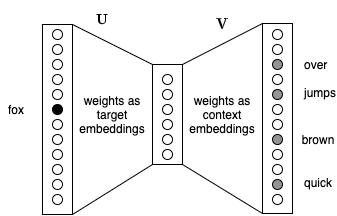!<br>
Lấy ví dụ về mô hình Skip-gram:<br>
Mục tiêu của mô hình là maximize xác suất có điều kiện của các từ context quick, brown, jumps khi biết từ target là fox
$P("quick","brown","jumps","over"|"fox")$<br>
Để đơn giản hóa mô hình chúng ta giả sử xác suất có điều kiện của các từ context là độc lập nghĩa là
$P("quick","brown","jumps","over"|"fox") = P("quick"|"fox")P("brown"|"fox")P("jumps"|"fox")P("over"|"fox")$<br>
Hay chính là tối thiểu hóa hàm Negative Log Likelihood sau:<br>
$\large \mathcal{L}(\mathbf{U}, \mathbf{V}; w_t) = -\sum_{c \in \mathcal{C}_t} \log \frac{\exp(\mathbf{u}_t^T\mathbf{v}_c)}{\sum_{i=1}^{N}\exp(\mathbf{u}_t^T\mathbf{v}_i)}$<br>
U ở đây chính là ma trận có kích thước ```số chiều embedding * số từ của từ điển```. Thông thường các vector đầu vào của mô hình chính là one-hot vector nên khi nhân với ma trận U thì sẽ cho kết quả là 1 vector cột có số thứ tự là số thứ tự của từ đầu vào trong từ điển $\bf{u}_t$ cho từ thứ t trong từ điển. Như vậy bản chất vector $\bf{u}_t$ chính là vector embedding của từ đó.<br>
V tương tự như U nhưng có kích thước ngược lại so với U. mỗi cột trong V sẽ là 1 vector có số chiều là ```số chiều embedding * 1```. Như vậy mỗi vector cột $\bf{v_c}$ lại ứng với dạng được gọi là context vector của từ thứ c trong từ điển.<br>
=> Bản chất của phép nhân ma trận trên là nhân vector embedding với từng vector context sao cho với context là vector của từ đứng cạnh từ fox như quick brown,... thì kết quả của phép nhân trên là lớn hơn so với các vector context khác.
[Read more here (in Vietnamese)](https://machinelearningcoban.com/tabml_book/ch_embedding/word2vec.html)


### Prepare Word2Vec Model using Gensim
Sử dụng ngay corpus chính là dataset này để training word2vec do các corpus khác cho kết quả không quá tốt.

In [ ]:
# Tạo corpus từ chính dataset đang sử dụng trong competition cụ thể là các cột description, title, search_term
temp = train_df['product_description']
temp = np.concatenate((temp, test_df['product_description']), axis=0)
temp = np.unique(temp)
sentences = [i.split(' ') for i in temp]
temp = train_df['search_term']
temp = np.concatenate((temp, test_df['search_term']), axis=0)
temp = np.unique(temp)
temp = [i.split(' ') for i in temp]
sentences.extend(temp)
temp = train_df['product_title']
temp = np.concatenate((temp, test_df['product_title']), axis=0)
temp = np.unique(temp)
temp = [i.split(' ') for i in temp]
sentences.extend(temp)
len(sentences)

In [ ]:
!pip install -U gensim

In [ ]:
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

# Bởi vì loss do gensim tính là cummulative loss (tổng loss từ epoch đầu đến epoch đang xét) nên cần tính = cách
# lấy loss epoch sau trừ loss epoch trước đó.
class callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''
    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0
    
    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        self.epoch += 1
        
#Train tổng cộng 20 epochs với vector dimension là 100 và window là 5
model = Word2Vec(sentences=sentences, vector_size=100, window=5, workers=4, min_count=1, 
                 compute_loss=True, callbacks=[callback()], epochs=20)
model.save('w2v_homedepot_100_2.model')

In [ ]:
# Load Pretrained Word2Vec Model
model = Word2Vec.load("w2v_homedepot_100_2.model")
vector1 = model.wv['computer']  # get numpy vector of a word
vector2 = model.wv['fax']
sims = model.wv.most_similar('computer', topn=10)  # get other similar words
sims

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([vector1], [vector2]).max(axis=1).shape[0]

### Word2Vec Cosine Similarity
Tìm max Cosine Similarity của 1 word trong search_term và 1 word trong title

In [ ]:
def getW2VSearchTermMaxSimScoreTitle(row):
    title = row['product_title'].strip().split(' ')
    search_term = row['search_term'].strip().split(' ')
    title_vec =  [model.wv[title_].tolist() for title_ in title if title_ in model.wv]
    search_term_vec = [model.wv[search_term_].tolist() for search_term_ in search_term if search_term_ in model.wv]
    mean = 0.0
    if len(search_term_vec) == 0 or len(title_vec) == 0: return 0
    score_matrix = cosine_similarity(search_term_vec, title_vec)
    score_matrix = score_matrix.max(axis = 1)
    assert(score_matrix.shape[0] == len(search_term_vec)) 
    mean = score_matrix.sum()/len(search_term_vec)
    return mean
train_df['max_cosine_sim_per_word_st_pt'] = train_df.progress_apply(getW2VSearchTermMaxSimScoreTitle, axis=1)

test_df['max_cosine_sim_per_word_st_pt'] = test_df.progress_apply(getW2VSearchTermMaxSimScoreTitle, axis=1)


Tìm max Cosine Similarity của 1 word trong search_term và 1 word trong description

In [ ]:
def getW2VSearchTermMaxSimScoreDes(row):
    title = row['product_description'].strip().split(' ')
    search_term = row['search_term'].strip().split(' ')
    
    # Lấy list các vector của các từ trong title nếu chúng có trong model
    title_vec =  [model.wv[title_].tolist() for title_ in title if title_ in model.wv]
    
    # Lấy list các vector của các từ trong search_term nếu chúng có trong model
    search_term_vec = [model.wv[search_term_].tolist() for search_term_ in search_term if search_term_ in model.wv]
    
    mean = 0.0
    # Nếu như không có word nào tồn tại trong word2vec list của model trong search_term hoặc title thì return 0
    if len(search_term_vec) == 0 or len(title_vec) == 0: return 0
    
    # Tính cosine sim theo dạng ma trận
    score_matrix = cosine_similarity(search_term_vec, title_vec)
    # Lấy giá trị lớn nhất của mỗi hàng ứng với cosine sim lớn nhất của 1 word trong search_term với 1 từ nào đó trong title
    score_matrix = score_matrix.max(axis = 1)
    assert(score_matrix.shape[0] == len(search_term_vec)) 
    mean = score_matrix.sum()/len(search_term_vec)
    return mean
train_df['max_cosine_sim_per_word_st_pd'] = train_df.progress_apply(getW2VSearchTermMaxSimScoreDes, axis=1)

test_df['max_cosine_sim_per_word_st_pd'] = test_df.progress_apply(getW2VSearchTermMaxSimScoreDes, axis=1)


Tính **n_similarity** (một dạng tính cosine sim nhưng cho 2 câu chứ không phải 2 word bằng cách lấy mean của tất cả các vector trong 2 câu và tính cosine sim trên 2 vector mean đó)

In [ ]:
def w2v_n_sim_st_pt(row):
    title = row['product_title'].strip().split(' ')
    search_term = row['search_term'].strip().split(' ')
    title = [i for i in title if i in model.wv]
    search_term = [i for i in search_term if i in model.wv]
    if not len(title) or not len(search_term): return 0
    return model.wv.n_similarity(title, search_term)

train_df['w2v_n_similarity_st_pt'] = train_df.progress_apply(w2v_n_sim_st_pt, axis=1)

test_df['w2v_n_similarity_st_pt'] = test_df.progress_apply(w2v_n_sim_st_pt, axis=1)


In [ ]:
def w2v_n_sim_st_pd(row):
    description = row['product_description'].strip().split(' ')
    search_term = row['search_term'].strip().split(' ')
    description = [i for i in description if i in model.wv]
    search_term = [i for i in search_term if i in model.wv]
    if not len(description) or not len(search_term): return 0
    return model.wv.n_similarity(description, search_term)

train_df['w2v_n_similarity_st_pd'] = train_df.progress_apply(w2v_n_sim_st_pd, axis=1)

test_df['w2v_n_similarity_st_pd'] = test_df.progress_apply(w2v_n_sim_st_pd, axis=1)


**Word2Vec centroid RMSE**, feature này không đem lại quá nhiều giá trị, được tính bằng cách lấy mean của các vector word trong câu rồi tính RMSE dựa trên 2 mean vector của 2 câu đó)

In [ ]:
from sklearn.metrics import mean_squared_error
def w2v_centroid_rmse_st_pd(row):
    description = row['product_description'].strip().split(' ')
    search_term = row['search_term'].strip().split(' ')
    description = [model.wv[i] for i in description if i in model.wv]
    search_term = [model.wv[i] for i in search_term if i in model.wv]
    if not len(description) or not len(search_term): return 0
    mean_des = np.mean(description, axis=0)
    mean_ser = np.mean(search_term, axis=0)
    return mean_squared_error(mean_ser, mean_des)

train_df['w2v_centroid_rmse_st_pd'] = train_df.progress_apply(w2v_centroid_rmse_st_pd, axis=1)

test_df['w2v_centroid_rmse_st_pd'] = test_df.progress_apply(w2v_centroid_rmse_st_pd, axis=1)


In [ ]:
from sklearn.metrics import mean_squared_error
def w2v_centroid_rmse_st_pt(row):
    description = row['product_title'].strip().split(' ')
    search_term = row['search_term'].strip().split(' ')
    description = [model.wv[i] for i in description if i in model.wv]
    search_term = [model.wv[i] for i in search_term if i in model.wv]
    if not len(description) or not len(search_term): return 0
    mean_des = np.mean(description, axis=0)
    mean_ser = np.mean(search_term, axis=0)
    return mean_squared_error(mean_ser, mean_des)

train_df['w2v_centroid_rmse_st_pt'] = train_df.progress_apply(w2v_centroid_rmse_st_pt, axis=1)

test_df['w2v_centroid_rmse_st_pt'] = test_df.progress_apply(w2v_centroid_rmse_st_pt, axis=1)


In [ ]:
train_df.corr()

## TF-IDF Feature

TFIDF, viết tắt từ cụm từ tiếng Anh: term frequency–inverse document frequency, là một thống kê số học nhằm phản ánh tầm quan trọng của một từ đối với một văn bản trong một tập hợp hay một ngữ liệu văn bản (định nghĩa bởi Wikipedia).<br>
Ý tưởng chính của TFIDF đó là đánh giá các từ dựa trên tần suất xuất hiện của từ đó trong văn bản đang xét và tần suất xuất hiện của từ đó trong toàn bộ các văn bản (số lượng văn bản mà từ đó có xuất hiện). <br>
TFIDF giúp khắc phục nhược điểm của các từ phổ biến (ví dụ stopword) có tần suất quá lớn trong khi đó các từ quan trọng xuất hiện với tần suất vừa phải hơn nhưng có giá trị tần suất nhỏ hơn các từ đó. Tuy nhiên TFIDF không giải quyết được vấn đề về vị trí của từ trong câu cũng như vấn đề về ngữ nghĩa (semantics).<br>

**TF- term frequency** – tần số xuất hiện của 1 từ trong 1 văn bản. Cách tính:

${\displaystyle \mathrm {tf} (t,d)={\frac {\mathrm {f} (t,d)}{\max\{\mathrm {f} (w,d):w\in d\}}}}$
Thương của số lần xuất hiện 1 từ trong văn bản và số lần xuất hiện nhiều nhất của một từ bất kỳ trong văn bản đó. (giá trị sẽ thuộc khoảng $[0, 1]$).<br>
* $f(t,d)$ - số lần xuất hiện từ t trong văn bản d.
* $max{f(w,d):w∈d}$ - số lần xuất hiện nhiều nhất của một từ bất kỳ trong văn bản.

**IDF – inverse document frequency**. Tần số nghịch của 1 từ trong tập văn bản (corpus).

Tính IDF để giảm giá trị của những từ phổ biến. Mỗi từ chỉ có 1 giá trị IDF duy nhất trong tập văn bản.

${\displaystyle \mathrm {idf} (t,D)=\log {\frac {|D|}{|\{d\in D:t\in d\}|}}}$
* ${\displaystyle |D|}{\displaystyle |D|}$: - tổng số văn bản trong tập D
* ${\displaystyle |\{d\in D:t\in d\}|}{\displaystyle |\{d\in D:t\in d\}|}$: - số văn bản chứa từ nhất định, với điều kiện ${\displaystyle t}$ xuất hiện trong văn bản d (i.e., ${\displaystyle \mathrm {tf} (t,d)\neq 0}$).
* Nếu từ đó không xuất hiện ở bất cứ 1 văn bản nào trong tập thì mẫu số sẽ bằng 0 => phép chia cho không không hợp lệ, vì thế người ta thường thay bằng mẫu thức ${\displaystyle 1+|\{d\in D:t\in d\}|}$. (là tham số **smooth_idf** trong sklearn)

### Prepare TFIDF using TFIDF Vectorizer (sklearn)

Dữ liệu được sử dụng để fit TFIDF Vectorizer ở đây là dữ liệu về title + description của các sản phẩm trong dataset (đã loại bỏ trùng lặp).<br>
Vectorizer được config lấy tối đa 10000 word (max_features) được lấy theo thứ tự từ cao đến bé giá trị TF của từ.<br>
Bởi vì số lượng chiều là 10000 quá lớn nên cần thiết phải sử dụng 1 phương pháp giảm bớt số chiều của vector mà vẫn giữ lại được nhiều thông tin chính. Có thể sử dụng SVD hoặc PCA, ở đây em dùng TruncatedSVD của sklearn để giảm số chiều từ 10000 xuống còn 500.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

title_desc_train = train_df["product_title"].astype(str) + '. ' + train_df["product_description"].astype(str)
title_desc_test = test_df["product_title"].astype(str) + '. ' + test_df["product_description"].astype(str)
title_desc_all =  title_desc_train.append(title_desc_test)
title_desc_unique = title_desc_all.unique()
vectorizer = TfidfVectorizer(smooth_idf=True, min_df=2, max_features=10000, stop_words='english')

vectorizer.fit(title_desc_unique)

X_title_desc_all = vectorizer.transform(title_desc_all)

X_title_desc_train = vectorizer.transform(title_desc_train)
print(X_title_desc_train.shape) # check shape of the document-term matrix

X_title_desc_test = vectorizer.transform(title_desc_test)

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=500, algorithm='randomized', n_iter=10, random_state=122)
svd_model.fit(X_title_desc_all)

truncated_title_desc_train = svd_model.transform(X_title_desc_train)

truncated_title_desc_test = svd_model.transform(X_title_desc_test)

print(truncated_title_desc_train.shape)
tsvd_var_ratios = svd_model.explained_variance_ratio_
print('variance explained', tsvd_var_ratios.sum())

X_search = vectorizer.transform(train_df['search_term'])
print(X_search.shape) # check shape of the document-term matrix

transformed_search_train = svd_model.transform(X_search)

X_search = vectorizer.transform(test_df['search_term'])
print(X_search.shape) # check shape of the document-term matrix

transformed_search_test = svd_model.transform(X_search)

### TFIDF Cosine similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
# Tính cosine similarity của từng cặp search_term và (title+des) (sentence level) sau khi đã truncated
cosine_similarity_tfidf_search_title_des = [cosine_similarity([x], [y]) for x,y in zip(transformed_search_train, truncated_title_desc_train)]
train_df['cosine_similarity_tfidf_search_title_des'] = [i[0][0] for i in cosine_similarity_tfidf_search_title_des]

cosine_similarity_tfidf_search_title_des = [cosine_similarity([x], [y]) for x,y in zip(transformed_search_test, truncated_title_desc_test)]
test_df['cosine_similarity_tfidf_search_title_des'] = [i[0][0] for i in cosine_similarity_tfidf_search_title_des]

In [ ]:
truncated_pt_train = svd_model.transform(vectorizer.transform(train_df["product_title"].astype(str)))
truncated_pt_test = svd_model.transform(vectorizer.transform(test_df["product_title"].astype(str)))
# Tính cosine similarity của từng cặp search_term và title (sentence level) sau khi đã truncated
cosine_similarity_tfidf_search_title = [cosine_similarity([x], [y]) for x,y in zip(transformed_search_train, truncated_pt_train)]
train_df['cosine_similarity_tfidf_search_title'] = [i[0][0] for i in cosine_similarity_tfidf_search_title]
cosine_similarity_tfidf_search_title = [cosine_similarity([x], [y]) for x,y in zip(transformed_search_test, truncated_pt_test)]
test_df['cosine_similarity_tfidf_search_title'] = [i[0][0] for i in cosine_similarity_tfidf_search_title]

truncated_pd_train = svd_model.transform(vectorizer.transform(train_df["product_description"].astype(str)))
truncated_pd_test = svd_model.transform(vectorizer.transform(test_df["product_description"].astype(str)))

# Tính cosine similarity của từng cặp search_term và des (sentence level) sau khi đã truncated
cosine_similarity_tfidf_search_des = [cosine_similarity([x], [y]) for x,y in zip(transformed_search_train, truncated_pd_train)]
train_df['cosine_similarity_tfidf_search_des'] = [i[0][0] for i in cosine_similarity_tfidf_search_des]
cosine_similarity_tfidf_search_des = [cosine_similarity([x], [y]) for x,y in zip(transformed_search_test, truncated_pd_test)]
test_df['cosine_similarity_tfidf_search_des'] = [i[0][0] for i in cosine_similarity_tfidf_search_des]

## BM25 Ranking
Feature này được lấy từ một tutorial về dataset này ([Link](https://towardsdatascience.com/modeling-product-search-relevance-in-e-commerce-home-depot-case-study-8ccb56fbc5ab)) <br>
BM25 được sử dụng trong các engine tìm kiếm cổ điển ngày trước có công thức như sau: <br>
$\large{\displaystyle {\text{score}}(D,Q)=\sum _{i=1}^{n}{\text{IDF}}(q_{i})\cdot {\frac {f(q_{i},D)\cdot (k_{1}+1)}{f(q_{i},D)+k_{1}\cdot \left(1-b+b\cdot {\frac {|D|}{\text{avgdl}}}\right)}}}$ <br>
Trong đó: 
* $Q$ là query (search_term) còn $D$ chính là document cần đánh giá relevance (ở đây là product_title or description).
* $IDF(q_i)$ chính là Inverse Document Frequency trong TFIDF.
* $f(q_i, D)$ là TF của word $q_i$ trong cụm query $Q$ với document $D$.
* $avgdl$ là độ dài trung bình của các document.
* $|D|$ là độ dài của document đang xét.
* $k_1$ và $b$ là tham số tự do thường chọn là  ${\displaystyle k_{1}\in [1.2,2.0]}$ $b=0.75$

In [ ]:
def bm25_fit(corpus):
    tfidf_model = TfidfVectorizer(smooth_idf=False, token_pattern=r"(?u)\b\w+\b")
    tfidf_model.fit(corpus)
    idf_dict = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
    avgdl = np.mean([len(doc.split()) for doc in corpus])
    params = {'idf_dict': idf_dict, 
            'avgdl' : avgdl,
            'N' : len(corpus)}
    return params
# Các tham số đã giải thích trên phần công thức
def bm25_score(query, doc, params, k=1.2, b=0.75):

    idf_dict = params['idf_dict']
    avgdl = params['avgdl']
    N = params['N']
    score_query = 0

    for word in query.split():
        dl = len(doc.split())
        tf = doc.count(word)
        if word in idf_dict.keys():
            idf = idf_dict[word]
        else: 
            idf = np.log(N+1) 

        score_word = idf*(tf*(k+1))/(tf + k*(1-b) + b*dl/avgdl)
        score_query += score_word

    return score_query

params_bm25_title = bm25_fit(train_df['product_title'])
train_df['bm25_ST'] = train_df.progress_apply(lambda row: bm25_score(row['search_term'], row['product_title'], params_bm25_title), axis=1)
train_df['bm25_ST'] = train_df.progress_apply(lambda row: bm25_score(row['search_term'], row['product_title'], params_bm25_title), axis=1)

# params_bm25_title = bm25_fit(test_df['product_title'])
test_df['bm25_ST'] = test_df.progress_apply(lambda row: bm25_score(row['search_term'], row['product_title'], params_bm25_title), axis=1)
test_df['bm25_ST'] = test_df.progress_apply(lambda row: bm25_score(row['search_term'], row['product_title'], params_bm25_title), axis=1)

## Min,Max TF, IDF

Chỉ đơn thuẩn là loop qua các từ trong search term sau đó tính TF, IDF, TFIDF min max và sum của các giá trị vừa nói ở trong title của sản phẩm. 

In [ ]:
# Train set

idf_dict = dict(zip(vectorizer.get_feature_names(), list(vectorizer.idf_)))
N = len(title_desc_unique)
params = {'idf_dict':idf_dict, 'N':N}

max_tf = []
max_idf = []
max_tfidf = []

min_tf = []
min_idf = []
min_tfidf = []

sum_tf = []
sum_idf = []
sum_tfidf = []


for ind, row in train_df.iterrows():
    search = row['search_term']
    text = row['product_title']
    tf_vals = []
    idf_vals = []
    tfidf_vals = []
    for word in search.split():
        if word in idf_dict.keys():
            tf = text.count(word)
            idf = idf_dict[word]
        else:
            tf = text.count(word)
            idf = np.log(N+1)

        tf_vals.append(tf)
        idf_vals.append(idf)
        tfidf_vals.append(tf*idf)
  
    max_tf.append(max(tf_vals))
    min_tf.append(min(tf_vals))
    sum_tf.append(sum(tf_vals))

    max_idf.append(max(idf_vals))
    min_idf.append(min(idf_vals))
    sum_idf.append(sum(idf_vals))

    max_tfidf.append(max(tfidf_vals))
    min_tfidf.append(min(tfidf_vals))
    sum_tfidf.append(sum(tfidf_vals))

train_df['max_tf_ST'] = max_tf
train_df['max_idf_ST'] = max_idf
train_df['max_tfidf_ST'] = max_tfidf

train_df['min_tf_ST'] = min_tf
train_df['min_idf_ST'] = min_idf
train_df['min_tfidf_ST'] = min_tfidf

train_df['sum_tf_ST'] = sum_tf
train_df['sum_idf_ST'] = sum_idf
train_df['sum_tfidf_ST'] = sum_tfidf

In [ ]:
# Test set

idf_dict = dict(zip(vectorizer.get_feature_names(), list(vectorizer.idf_)))
N = len(title_desc_unique)
params = {'idf_dict':idf_dict, 'N':N}

max_tf = []
max_idf = []
max_tfidf = []

min_tf = []
min_idf = []
min_tfidf = []

sum_tf = []
sum_idf = []
sum_tfidf = []


for ind, row in test_df.iterrows():
    search = row['search_term']
    text = row['product_title']
    tf_vals = []
    idf_vals = []
    tfidf_vals = []
    for word in search.split():
        if word in idf_dict.keys():
            tf = text.count(word)
            idf = idf_dict[word]
        else:
            tf = text.count(word)
            idf = np.log(N+1)

        tf_vals.append(tf)
        idf_vals.append(idf)
        tfidf_vals.append(tf*idf)
  
    max_tf.append(max(tf_vals))
    min_tf.append(min(tf_vals))
    sum_tf.append(sum(tf_vals))

    max_idf.append(max(idf_vals))
    min_idf.append(min(idf_vals))
    sum_idf.append(sum(idf_vals))

    max_tfidf.append(max(tfidf_vals))
    min_tfidf.append(min(tfidf_vals))
    sum_tfidf.append(sum(tfidf_vals))

test_df['max_tf_ST'] = max_tf
test_df['max_idf_ST'] = max_idf
test_df['max_tfidf_ST'] = max_tfidf

test_df['min_tf_ST'] = min_tf
test_df['min_idf_ST'] = min_idf
test_df['min_tfidf_ST'] = min_tfidf

test_df['sum_tf_ST'] = sum_tf
test_df['sum_idf_ST'] = sum_idf
test_df['sum_tfidf_ST'] = sum_tfidf

In [ ]:
train_df.corr()

In [ ]:
train_df.corr().abs().sort_values(by='relevance', axis=0, ascending=False)['relevance'].to_dict().keys()

In [ ]:
train_df.to_csv('Feature_train.csv')
test_df.to_csv('Feature_test.csv')

# Model

Mô hình sử dụng:
* Random Forest
* Ridge (Cross Validation)
* HistGradientBoosting

**Về Random Forest:**
Ý tưởng của RF là dùng nhiều mô hình có bias thấp nhưng variance cao như Decision Tree để làm giảm variance của mô hình xuống. <br>
Giả sử mô hình DecisionTree của chúng ta là một biến ngẫu nhiên X có mean là 0 và variance là 1, với mỗi pack dữ liệu mà chúng ta lấy ra ngẫu nhiên và dùng chúng để training ta thu được 1 giá trị của X (một mô hình) gọi là $X_1$.<br>
Như vậy nếu chúng ta làm như trên b lần ta sẽ thu được b mô hình có $X_1$ đến $X_b$ (hay còn gọi là lấy mẫu, nhưng không phải lấy mẫu dữ liệu mà là lấy mẫu mô hình). Khi tính sample variance ta thu được là 1/b + p (con số p phản ánh việc lấy mẫu có độc lập với nhau hay không, nếu có p sẽ xấp xỉ 0) và variance sẽ giảm còn 1/b.<br>
[Một bài viết khá clear về mô hình này](https://towardsdatascience.com/understanding-the-effect-of-bagging-on-variance-and-bias-visually-6131e6ff1385).<br>
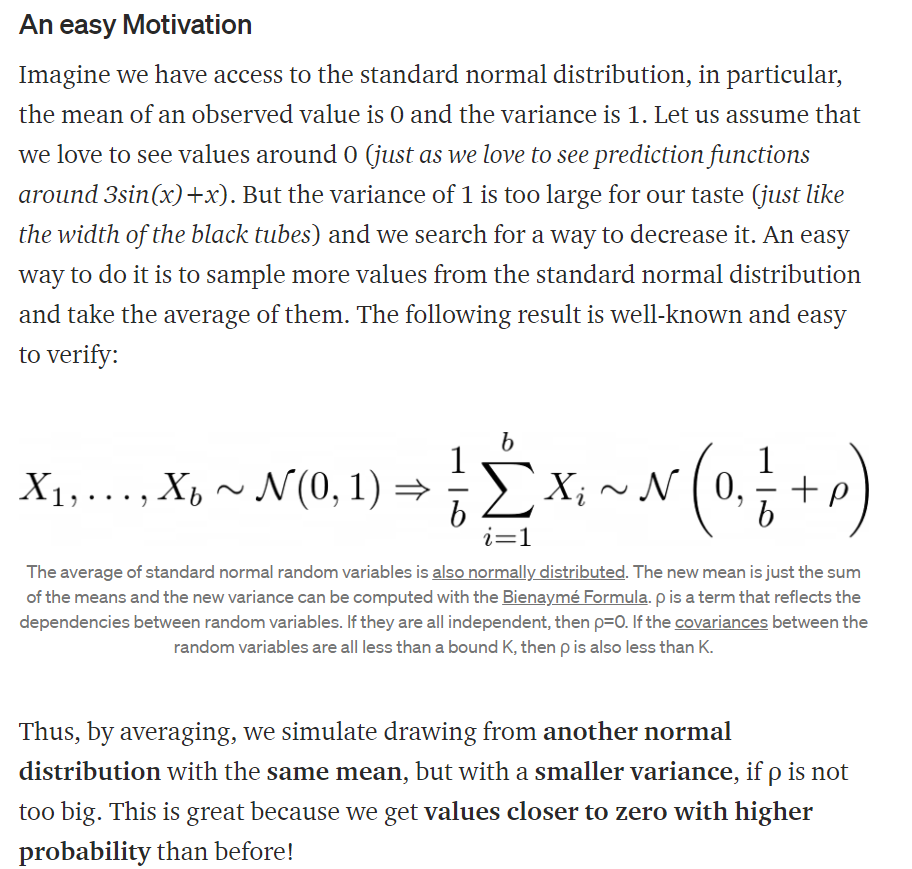<br>
Minh họa về việc sử dụng nhiều tree và 1 tree.<br>
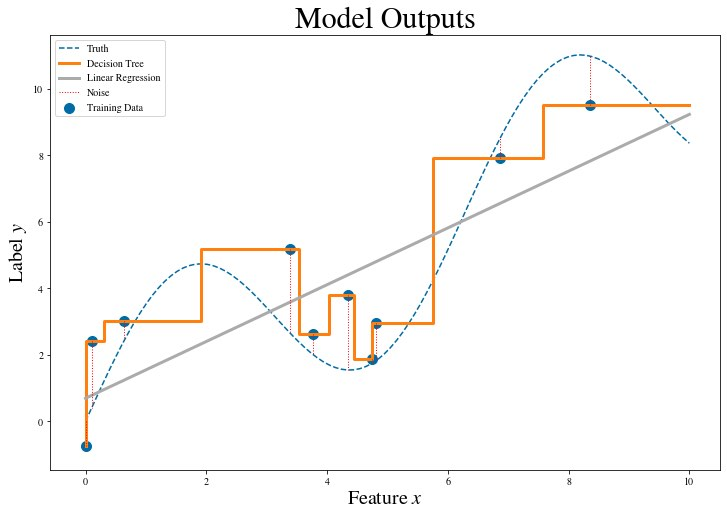<br>
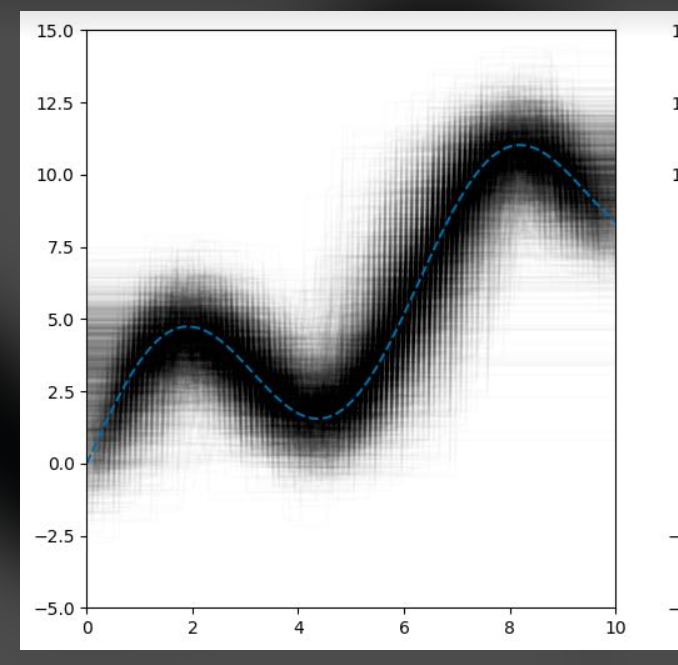

**Về Ridge:** <br>
Bản chất chính là Linear Regression nhưng Loss function được thêm vào 1 giá trị penalty khác gọi là L2 regularization để tránh mô hình bị overfit. L2 có giá trị = tổng bình phương của các weight mô hình đang học. L2 giúp weight có thể duy trì ở con số vừa phải (không quá lớn) nhằm tránh việc 1 future có ảnh hưởng quá lớn đến kết quả mà bỏ qua các feature khác dẫn đến overfit. <br>
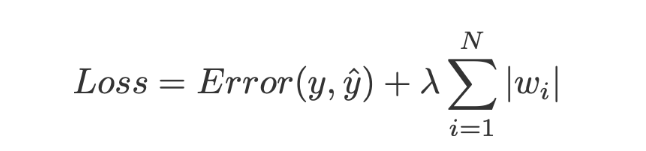

**Về GradientBoosting:** <br>
Do chưa tìm hiểu kỹ về HistGradientBoosting (LightGBM implementation) nhưng có lẽ về ý tưởng sẽ giống với GradientBoosting nên em sẽ viết về GB.<br>
Boosting là một phương pháp giúp tăng độ chính xác cho các mô hình có độ chính xác thấp (như Decision tree với độ sâu thấp).<br>
Ý tưởng chính của Boosting là cập nhật mô hình bằng tổ hợp tuyến tính của các mô hình yếu sao cho hàm lỗi giảm dần.\
Sau mỗi bước cộng đó, các giá trị dự đoán sai sẽ được cập nhật 1 trọng số để tăng giá trị hàm lỗi mà bộ giá trị đoán sai đó gây ảnh hưởng lên hàm lỗi trong bước tiếp theo.<br>
Các bước của GradientBoosting như hình sau:<br>
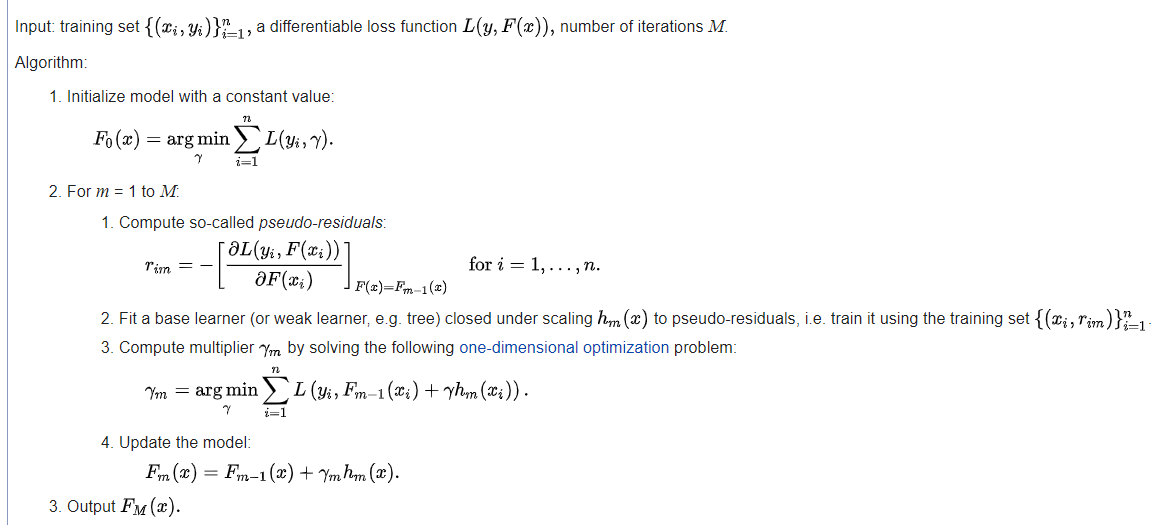 <br>
Điểm khác biệt của AdaBoost với GB nằm ở bước 2.1 và 2.2, chúng ta tính pseudo-residuals trên từng phần tử $x_i$ để thu được 1 dataset mới là {${(x_i, r_{im})}^{n}_{i=1}$} và weak leaner $h_m$ sẽ được train để fit với dataset mới này. <br>
Như vậy ý tưởng ở đây khá giống với gradient descent nếu chúng ta coi hàm lỗi là RMSE($y$,$\hat{y}$) và model là $F_{m-1}$ (trong trường hợp của GB thì chính là $\hat{y}$=$F_{m-1}$), nếu muốn tối thiểu hàm lỗi (coi $\hat{y}$ là biến của hàm lỗi) thì ta cần dịch chuyển biến $\hat{y}$ này ngược chiều của đạo hàm hàm lỗi (đạo hàm cho $\hat{y}$).<br>
Do đó khoảng dịch chuyển sẽ là ```đạo hàm * learning_rate```, việc đi tìm $h_m$ fit với đạo hàm là do $F_m = F_{m-1} + \gamma h_m(x)$ hay $\hat{y} = \hat{y} + \gamma h_m(x)$.<br>
Ở trên learning rate chính là $\gamma$ còn đạo hàm chính là $h_m(x)$ chỉ khác ở gradient descent ở chỗ $\gamma$ ở đây không phải hyperparameter mà hoàn toàn có thể tìm được nhờ giải bài toán tối ưu ở bước 2.3


In [ ]:
FEATURES_LIST = [
                'have_brand',
                'have_att',
                'query_length', 
                'search_term_include_brand',
                'cosine_ST',
                'cosine_SD',
                'min_jaccard_brand_with_search_term', 
                'min_edit_brand_with_search_term', 
                'sum_jaccard_product_title_with_search_term', 
                'mean_jaccard_product_des_with_search_term',
                'mean_jaccard_att_with_search_term',
                'last_word_in_title',
                # 'last_word_in_des',
                # 'last_word_in_brand',
                'number_in_att',
                'number_in_title',
                'number_in_des',
                'title_common_words_count',
                'des_common_words_count',
                'att_common_words_count',
                'title_common_words_count_2gram',
                'des_common_words_count_2gram',
                'att_common_words_count_2gram',
                'min_jaccard_title_with_search_term',
                'min_edit_title_with_search_term',
                'max_cosine_sim_per_word_st_pt',
                # 'cosine_similarity_tfidf_search_title_des',
                'cosine_similarity_tfidf_search_title',
                'cosine_similarity_tfidf_search_des',
                'bm25_ST',
                'max_idf_ST',
                'min_tf_ST',
                'min_tfidf_ST',
                'sum_tf_ST',
                'sum_idf_ST',
                'color_st_des',
                'color_st_title',
                'color_st_att',
                'max_cosine_sim_per_word_st_pd',
                'w2v_n_similarity_st_pt',
                'w2v_n_similarity_st_pd',
                # 'w2v_centroid_rmse_st_pd',
                # 'w2v_centroid_rmse_st_pt',
                'sum_jaccard_product_description_with_search_term',
                ]
# FEATURES_LIST = ['max_cosine_sim_per_word_st_pt', 'min_tf_ST', 'mean_jaccard_product_des_with_search_term', 'cosine_similarity_tfidf_search_title_des', 'min_tfidf_ST', 'sum_jaccard_product_title_with_search_term', 'last_word_in_title', 'bm25_ST', 'title_common_words_count', 'min_jaccard_title_with_search_term', 'last_word_in_des', 'min_edit_title_with_search_term', 'des_common_words_count', 'max_idf_ST', 'product_uid', 'id', 'sum_tf_ST', 'sum_idf_ST', 'sum_jaccard_product_description_with_search_term']

In [ ]:
from sklearn.decomposition import TruncatedSVD
svd_model2 = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=10, random_state=122)
transformed_pt_pd_unique = vectorizer.transform(title_desc_unique)
svd_model2.fit(transformed_pt_pd_unique)

Ở đây thực hiện việc concat các vector tfidf của search_term và title, description vào vector feature. Bước này làm theo 1 notebook trong forrum của kaggle. (em không hiểu lý do tại sao nhưng việc này thực sự improve kết quả submission)

In [ ]:
def getTFIDFVec(df, row_name, svd_model):
    np_arr = vectorizer.transform(df[row_name])
    return svd_model.transform(np_arr)

In [ ]:
#TFIDF Vector của search_term, title, des
st_vec = getTFIDFVec(train_df, 'search_term',svd_model2)
pt_vec = getTFIDFVec(train_df, 'product_title',svd_model2)
pd_vec = getTFIDFVec(train_df, 'product_description',svd_model2)

# Lấy vector feature đã chọn và convert sang numpy array để tiện concat với các vector TFIDF
new_train_df = train_df[FEATURES_LIST].to_numpy()
new_train_df= np.concatenate((new_train_df, st_vec), axis=1)
new_train_df = np.concatenate((new_train_df, pt_vec), axis=1)
new_train_df = np.concatenate((new_train_df, pd_vec), axis=1)

# Tương tự như trên với test dataframe
st_vec_submit = getTFIDFVec(test_df, 'search_term',svd_model2)
pt_vec_submit = getTFIDFVec(test_df, 'product_title',svd_model2)
pd_vec_submit = getTFIDFVec(test_df, 'product_description',svd_model2)

X_submit = test_df[FEATURES_LIST].to_numpy()
X_submit = np.concatenate((X_submit, st_vec_submit), axis=1)
X_submit = np.concatenate((X_submit, pt_vec_submit), axis=1)
X_submit = np.concatenate((X_submit, pd_vec_submit), axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_train_df, train_df['relevance'], test_size=0.2, random_state=42)

In [ ]:
from sklearn import ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV 

# Test thử với HistGradientBoosting
params_search = {
    "max_depth": [3, 4, 5, 6, 8],
    "learning_rate": [0.1, 0.01, 0.05],
    "loss": ["squared_error"],
    "max_iter": [100,200,400]
}
params = {  
            'learning_rate': 0.05,
            'max_depth': 8,
            'max_iter': 400
        }

gbr = HistGradientBoostingRegressor(**params)
gbr.fit(X_train, y_train)
# gbr = GridSearchCV(HistGradientBoostingRegressor(), params_search, refit = True, verbose = 3) 
# gbr.fit(X_train, y_train)


In [ ]:
rmse_test = math.sqrt(mean_squared_error(y_test, gbr.predict(X_test)))
rmse_train = math.sqrt(mean_squared_error(y_train, gbr.predict(X_train)))

print("Root mean square error (Test set): " + str(rmse_test))
print("Root mean square error (Train set): " + str(rmse_train))


Ở đây em đã sử dụng Gridsearch để tìm các hyperparameter cho các mô hình ở máy local (vì kaggle chạy rất chậm) sau đó mới stack các model lại để được một mô hình mạnh hơn với lv2 model là RidgeCV

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
estimators = [
    ('rfr', RandomForestRegressor(max_depth=8, random_state=1, min_samples_leaf=3)),
    ('hgbr', HistGradientBoostingRegressor(learning_rate=0.05, max_depth= 8, max_iter=600)),
    ('etg', ExtraTreesRegressor(n_estimators=100, random_state=0)),
    ('rcv', RidgeCV())
]
model = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
model.fit(X_train, y_train)



In [ ]:
rmse_test = math.sqrt(mean_squared_error(y_test, model.predict(X_test)))
rmse_train = math.sqrt(mean_squared_error(y_train, model.predict(X_train)))

print("Root mean square error (Test set): " + str(rmse_test))
print("Root mean square error (Train set): " + str(rmse_train))

# Make Submission

In [ ]:
rs = model.predict(X_submit)
test_df_temp = pd.read_csv('../input/home-depot-product-search-relevance/test.csv.zip', encoding='ISO-8859-1')
for index, i in enumerate(rs):
    if i < 1:
        rs[index] = 1
    if i > 3:
        rs[index] = 3
data = {
    'id': test_df_temp.id,
    'relevance': rs
}
submission = pd.DataFrame(data=data)
submission.to_csv('submission.csv', index=False)